## Identifying Duplicate Questions

Over 100 million people visit Quora every month, so it's no surprise that many people ask similar (or the same) questions. Various questions with the same intent can cause people to spend extra time searching for the best answer to their question, and results in members answering multiple versions of the same question. Quora uses random forest to identify duplicated questions to provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
Follow the steps outlined below to build the appropriate classifier model. 


Steps:
- Download data
- Exploration
- Cleaning
- Feature Engineering
- Modeling

By the end of this project you should have **a presentation that describes the model you built** and its **performance**. 


In [32]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv("train.csv")

#### Note
There is no designated test.csv file. The train.csv file is the entire dataset. Part of the data in the train.csv file should be set aside to act as the final testing data.

In [4]:
df

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
...,...,...,...,...,...,...
404285,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0
404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1
404287,404287,537928,537929,What is one coin?,What's this coin?,0
404288,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0


### Exploration

In [5]:
df.describe()

,id,qid1,qid2,is_duplicate
count,404290.000000,404290.000000,404290.000000,404290.000000
mean,202144.500000,217243.942418,220955.655337,0.369198
std,116708.614502,157751.700002,159903.182629,0.482588
min,0.000000,1.000000,2.000000,0.000000
25%,101072.250000,74437.500000,74727.000000,0.000000
50%,202144.500000,192182.000000,197052.000000,0.000000
75%,303216.750000,346573.500000,354692.500000,1.000000
max,404289.000000,537932.000000,537933.000000,1.000000


In [6]:
df.id.nunique()

404290

In [7]:
df.is_duplicate.value_counts()

0    255027
1    149263
Name: is_duplicate, dtype: int64

In [8]:
df.isna().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [9]:
df[df['question2'].isna()]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0


In [10]:
df = df.dropna()

In [31]:
df.isna().sum()

id                0
qid1              0
qid2              0
question1         0
question2         0
is_duplicate      0
tokenized_text    0
dtype: int64

<AxesSubplot:xlabel='is_duplicate', ylabel='count'>

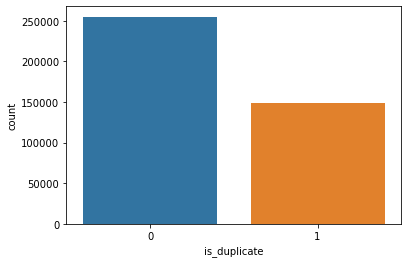

In [34]:
sns.countplot(x='is_duplicate', data=df)

In [51]:
df.is_duplicate.value_counts() / len(df)

0    0.630799
1    0.369201
Name: is_duplicate, dtype: float64

In [55]:
question_list = pd.concat([df['question1'] , df['question2']] )

In [58]:
question_list.value_counts()[question_list.value_counts()>1].head(10)

What are the best ways to lose weight?                                                                161
How can you look at someone's private Instagram account without following them?                       120
How can I lose weight quickly?                                                                        111
What's the easiest way to make money online?                                                           88
Can you see who views your Instagram?                                                                  79
What are some things new employees should know going into their first day at AT&T?                     77
What do you think of the decision by the Indian Government to demonetize 500 and 1000 rupee notes?     68
Which is the best digital marketing course?                                                            66
How can you increase your height?                                                                      63
How do l see who viewed my videos on Instagram

In [75]:
first_words = question_list.str.split(' ').str[0].value_counts().head(16)
first_words

What      272569
How       187437
Why        64810
Is         45774
Which      34329
Can        23280
I          18021
Who        15267
Do         13667
Where      13086
If         12165
What's     11062
Does       10038
Are         9129
Should      6410
When        6385
dtype: int64

<AxesSubplot:>

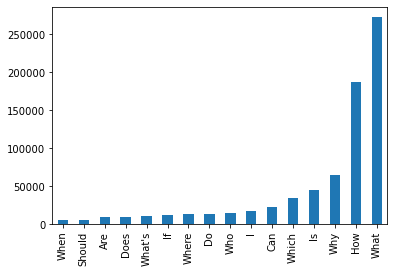

In [73]:
first_words.sort_values().plot(kind = 'bar')

### Cleaning

- Tokenization
- Stopwords cleaning
- Removing punctuation
- Normalizing
- Stemming

### Tokenization

In [38]:
df['tokenized_text'] = df['question1'].apply(word_tokenize)
df['tokenized_text2'] = df['question2'].apply(word_tokenize) 

C:\Users\Terre\AppData\Local\Temp\ipykernel_39736\99565562.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tokenized_text'] = df['question1'].apply(word_tokenize)
C:\Users\Terre\AppData\Local\Temp\ipykernel_39736\99565562.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tokenized_text2'] = df['question2'].apply(word_tokenize)


In [40]:
df[['tokenized_text', 'tokenized_text2']]

,tokenized_text,tokenized_text2
0,"[What, is, the, step, by, step, guide, to, inv...","[What, is, the, step, by, step, guide, to, inv..."
1,"[What, is, the, story, of, Kohinoor, (, Koh-i-...","[What, would, happen, if, the, Indian, governm..."
2,"[How, can, I, increase, the, speed, of, my, in...","[How, can, Internet, speed, be, increased, by,..."
3,"[Why, am, I, mentally, very, lonely, ?, How, c...","[Find, the, remainder, when, [, math, ], 23^, ..."
4,"[Which, one, dissolve, in, water, quikly, suga...","[Which, fish, would, survive, in, salt, water, ?]"
...,...,...
404285,"[How, many, keywords, are, there, in, the, Rac...","[How, many, keywords, are, there, in, PERL, Pr..."
404286,"[Do, you, believe, there, is, life, after, dea...","[Is, it, true, that, there, is, life, after, d..."
404287,"[What, is, one, coin, ?]","[What, 's, this, coin, ?]"
404288,"[What, is, the, approx, annual, cost, of, livi...","[I, am, having, little, hairfall, problem, but..."


### Stopwords Cleaning

In [16]:
stop_words = set(stopwords.words('english'))

In [41]:
df['tokenized_text'] = df['tokenized_text'].apply(lambda x: [item for item in x if item not in stop_words])
df['tokenized_text2'] = df['tokenized_text2'].apply(lambda x: [item for item in x if item not in stop_words])

C:\Users\Terre\AppData\Local\Temp\ipykernel_39736\563033868.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tokenized_text'] = df['tokenized_text'].apply(lambda x: [item for item in x if item not in stop_words])
C:\Users\Terre\AppData\Local\Temp\ipykernel_39736\563033868.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tokenized_text2'] = df['tokenized_text2'].apply(lambda x: [item for item in x if item not in stop_words])


In [43]:
df[['tokenized_text', 'tokenized_text2']]

,tokenized_text,tokenized_text2
0,"[What, step, step, guide, invest, share, marke...","[What, step, step, guide, invest, share, marke..."
1,"[What, story, Kohinoor, (, Koh-i-Noor, ), Diam...","[What, would, happen, Indian, government, stol..."
2,"[How, I, increase, speed, internet, connection...","[How, Internet, speed, increased, hacking, DNS..."
3,"[Why, I, mentally, lonely, ?, How, I, solve, ?]","[Find, remainder, [, math, ], 23^, {, 24, }, [..."
4,"[Which, one, dissolve, water, quikly, sugar, ,...","[Which, fish, would, survive, salt, water, ?]"
...,...,...
404285,"[How, many, keywords, Racket, programming, lan...","[How, many, keywords, PERL, Programming, Langu..."
404286,"[Do, believe, life, death, ?]","[Is, true, life, death, ?]"
404287,"[What, one, coin, ?]","[What, 's, coin, ?]"
404288,"[What, approx, annual, cost, living, studying,...","[I, little, hairfall, problem, I, want, use, h..."


### Lower Case/Normalizing

In [44]:
# change all to lower case
df['tokenized_text'] = df['tokenized_text'].apply(lambda x: [item.lower() for item in x])
df['tokenized_text2'] = df['tokenized_text2'].apply(lambda x: [item.lower() for item in x])

C:\Users\Terre\AppData\Local\Temp\ipykernel_39736\2555342378.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tokenized_text'] = df['tokenized_text'].apply(lambda x: [item.lower() for item in x])
C:\Users\Terre\AppData\Local\Temp\ipykernel_39736\2555342378.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tokenized_text2'] = df['tokenized_text2'].apply(lambda x: [item.lower() for item in x])


In [45]:
df[['tokenized_text', 'tokenized_text2']]

,tokenized_text,tokenized_text2
0,"[what, step, step, guide, invest, share, marke...","[what, step, step, guide, invest, share, marke..."
1,"[what, story, kohinoor, (, koh-i-noor, ), diam...","[what, would, happen, indian, government, stol..."
2,"[how, i, increase, speed, internet, connection...","[how, internet, speed, increased, hacking, dns..."
3,"[why, i, mentally, lonely, ?, how, i, solve, ?]","[find, remainder, [, math, ], 23^, {, 24, }, [..."
4,"[which, one, dissolve, water, quikly, sugar, ,...","[which, fish, would, survive, salt, water, ?]"
...,...,...
404285,"[how, many, keywords, racket, programming, lan...","[how, many, keywords, perl, programming, langu..."
404286,"[do, believe, life, death, ?]","[is, true, life, death, ?]"
404287,"[what, one, coin, ?]","[what, 's, coin, ?]"
404288,"[what, approx, annual, cost, living, studying,...","[i, little, hairfall, problem, i, want, use, h..."


### Remove Punctuation

In [46]:
df['tokenized_text'] = df['tokenized_text'].apply(lambda x: [item for item in x if item.isalpha()])
df['tokenized_text2'] = df['tokenized_text2'].apply(lambda x: [item for item in x if item.isalpha()])

C:\Users\Terre\AppData\Local\Temp\ipykernel_39736\891855239.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tokenized_text'] = df['tokenized_text'].apply(lambda x: [item for item in x if item.isalpha()])
C:\Users\Terre\AppData\Local\Temp\ipykernel_39736\891855239.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tokenized_text2'] = df['tokenized_text2'].apply(lambda x: [item for item in x if item.isalpha()])


In [47]:
df[['tokenized_text', 'tokenized_text2']]

,tokenized_text,tokenized_text2
0,"[what, step, step, guide, invest, share, marke...","[what, step, step, guide, invest, share, market]"
1,"[what, story, kohinoor, diamond]","[what, would, happen, indian, government, stol..."
2,"[how, i, increase, speed, internet, connection...","[how, internet, speed, increased, hacking, dns]"
3,"[why, i, mentally, lonely, how, i, solve]","[find, remainder, math, divided]"
4,"[which, one, dissolve, water, quikly, sugar, s...","[which, fish, would, survive, salt, water]"
...,...,...
404285,"[how, many, keywords, racket, programming, lan...","[how, many, keywords, perl, programming, langu..."
404286,"[do, believe, life, death]","[is, true, life, death]"
404287,"[what, one, coin]","[what, coin]"
404288,"[what, approx, annual, cost, living, studying,...","[i, little, hairfall, problem, i, want, use, h..."


### Stemming

In [23]:
porter = PorterStemmer()

In [48]:
df['tokenized_text'] = df['tokenized_text'].apply(lambda x: [porter.stem(item) for item in x])
df['tokenized_text2'] = df['tokenized_text2'].apply(lambda x: [porter.stem(item) for item in x])

C:\Users\Terre\AppData\Local\Temp\ipykernel_39736\851240336.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tokenized_text'] = df['tokenized_text'].apply(lambda x: [porter.stem(item) for item in x])
C:\Users\Terre\AppData\Local\Temp\ipykernel_39736\851240336.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tokenized_text2'] = df['tokenized_text2'].apply(lambda x: [porter.stem(item) for item in x])


In [89]:
df_t = df[['tokenized_text', 'tokenized_text2']]
df_t

,tokenized_text,tokenized_text2
0,"[what, step, step, guid, invest, share, market...","[what, step, step, guid, invest, share, market]"
1,"[what, stori, kohinoor, diamond]","[what, would, happen, indian, govern, stole, k..."
2,"[how, i, increas, speed, internet, connect, us...","[how, internet, speed, increas, hack, dn]"
3,"[whi, i, mental, lone, how, i, solv]","[find, remaind, math, divid]"
4,"[which, one, dissolv, water, quikli, sugar, sa...","[which, fish, would, surviv, salt, water]"
...,...,...
404285,"[how, mani, keyword, racket, program, languag,...","[how, mani, keyword, perl, program, languag, l..."
404286,"[do, believ, life, death]","[is, true, life, death]"
404287,"[what, one, coin]","[what, coin]"
404288,"[what, approx, annual, cost, live, studi, uic,...","[i, littl, hairfal, problem, i, want, use, hai..."


In [91]:
df_t['word_overlap'] = [set(x[0]) & set(x[1]) for x in df_t.values]

C:\Users\Terre\AppData\Local\Temp\ipykernel_39736\263032284.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t['word_overlap'] = [set(x[0]) & set(x[1]) for x in df_t.values]


In [93]:
df_t

,tokenized_text,tokenized_text2,word_overlap
0,"[what, step, step, guid, invest, share, market...","[what, step, step, guid, invest, share, market]","{guid, share, market, what, invest, step}"
1,"[what, stori, kohinoor, diamond]","[what, would, happen, indian, govern, stole, k...","{diamond, kohinoor, what}"
2,"[how, i, increas, speed, internet, connect, us...","[how, internet, speed, increas, hack, dn]","{increas, internet, speed, how}"
3,"[whi, i, mental, lone, how, i, solv]","[find, remaind, math, divid]",{}
4,"[which, one, dissolv, water, quikli, sugar, sa...","[which, fish, would, surviv, salt, water]","{which, salt, water}"
...,...,...,...
404285,"[how, mani, keyword, racket, program, languag,...","[how, mani, keyword, perl, program, languag, l...","{program, languag, keyword, mani, latest, vers..."
404286,"[do, believ, life, death]","[is, true, life, death]","{death, life}"
404287,"[what, one, coin]","[what, coin]","{what, coin}"
404288,"[what, approx, annual, cost, live, studi, uic,...","[i, littl, hairfal, problem, i, want, use, hai...",{}


In [98]:
df_t['overlap_count'] = df_t['word_overlap'].str.len()

C:\Users\Terre\AppData\Local\Temp\ipykernel_39736\2851164045.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t['overlap_count'] = df_t['word_overlap'].str.len()


In [108]:
df_t['len'] = df_t['tokenized_text'].str.len()

C:\Users\Terre\AppData\Local\Temp\ipykernel_39736\1390557936.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t['len'] = df_t['tokenized_text'].str.len()


In [109]:
df_t['length_percentage'] = df_t['overlap_count']/df_t['len']

C:\Users\Terre\AppData\Local\Temp\ipykernel_39736\3062151882.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t['length_percentage'] = df_t['overlap_count']/df_t['len']


In [110]:
df_t[['tokenized_text', 'tokenized_text2', 'overlap_count', 'len','length_percentage']]

,tokenized_text,tokenized_text2,overlap_count,len,length_percentage
0,"[what, step, step, guid, invest, share, market...","[what, step, step, guid, invest, share, market]",6,8,0.750000
1,"[what, stori, kohinoor, diamond]","[what, would, happen, indian, govern, stole, k...",3,4,0.750000
2,"[how, i, increas, speed, internet, connect, us...","[how, internet, speed, increas, hack, dn]",4,8,0.500000
3,"[whi, i, mental, lone, how, i, solv]","[find, remaind, math, divid]",0,7,0.000000
4,"[which, one, dissolv, water, quikli, sugar, sa...","[which, fish, would, surviv, salt, water]",3,11,0.272727
...,...,...,...,...,...
404285,"[how, mani, keyword, racket, program, languag,...","[how, mani, keyword, perl, program, languag, l...",7,8,0.875000
404286,"[do, believ, life, death]","[is, true, life, death]",2,4,0.500000
404287,"[what, one, coin]","[what, coin]",2,3,0.666667
404288,"[what, approx, annual, cost, live, studi, uic,...","[i, littl, hairfal, problem, i, want, use, hai...",0,10,0.000000


### Feature Engineering

- tf-idf
- word2vec
- word count
- number of the same words in both questions
- ....

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [79]:
vectorizer = TfidfVectorizer(max_features= 5000)

In [80]:
x = vectorizer.fit_transform(df['question1'])

In [81]:
x.toarray()

MemoryError: Unable to allocate 15.1 GiB for an array with shape (404287, 5000) and data type float64

In [77]:
x

<404287x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 3677723 stored elements in Compressed Sparse Row format>

### Word2Vec

In [ ]:
# from gensim.models import Word2Vec

In [ ]:
# word2vec = Word2Vec(sentences = df['tokenized_text'], min_count=2)

In [ ]:
# word2vec

### Modeling

Different modeling techniques can be used:

- logistic regression
- XGBoost
- LSTMs
- etc